In [1]:
import json
import glob
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from asap3 import EMT
from ase.io import write, read

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from surface_seg.envs.symmetry_function import make_snn_params, wrap_symmetry_functions


In [13]:
def sortby(x):
    try:
        return int(x.split('_')[-1].split('.txt')[0])
    except ValueError:
        return float('inf')
    
def get_features(results_list, fps_or_pos='pos'):
    fps = []
    pos = []
    energies = []
    
    for result in tqdm.tqdm(results_list):
        with open(result, 'r') as f:
            data = json.load(f)
        if fps_or_pos == 'fps':
            fps.append(data['fingerprints'])
        elif fps_or_pos == 'pos':
            pos.append(data['positions'])
        elif fps_or_pos == 'both':
            fps.append(data['fingerprints'])
            pos.append(data['positions'])
            
        energies.append(data['energies'])
                
    return np.concatenate(fps), np.concatenate(pos), np.concatenate(energies)

def _PCA(features, energies, n_components=2):
    data = pd.DataFrame(data=features)
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_data = pca.transform(data)
    pca_data = pd.DataFrame(pca_data[:,:2], columns = ['pc1', 'pc2'])
    pca_data['energies'] = energies
    
    return pca_data

def plot_PCA(features, n_components=2, per_atom=False):
    
    if per_atom:
        fig, axs = plt.subplots(2, 4, figsize=(25,10))
        fig.subplots_adjust(hspace =.5, wspace=.4)
        axs = axs.ravel()
        for i in range(features.shape[1]): # for each free atom,
            pca_data = _PCA(features[:,i], energies, n_components=2)
            pca = axs[i].scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=1)
            axs[i].set_xlabel('pc 1', fontsize=15)
            axs[i].set_ylabel('pc 2', fontsize=15)
            axs[i].set_title('atom %d' %i)
            cbar = fig.colorbar(pca, ax = axs[i])
            cbar.set_label("energies", fontsize=15)

    else:
        features = features.reshape(len(features), -1)
        pca_data = _PCA(features, energies, n_components=2)

        plt.figure(figsize=(12,10))
        plt.scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=0.5)
        plt.xlabel('pc 1', fontsize=20)
        plt.ylabel('pc 2', fontsize=20)
        cbar = plt.colorbar()
        cbar.set_label("energies", fontsize=20)
        
    plt.show()
    return


# Load entire results

In [3]:
results_dir = './result_trpo/fps_scaled_or/results/*.txt'

results_list = glob.glob(results_dir)

print('Load %d trajectories' %len(results_list))
results_list.sort(key=sortby)

Load 200 trajectories


# Generate features (fingerprints or positions or both)

In [14]:
fps, pos, energies = get_features(results_list, fps_or_pos='both')
print(np.min(energies), np.max(energies))
#### NOTES
# Saving fingerprints in each episode takes ~1.5 MB
# Saving .traj only takes ~500 kB, but generating fingerprints afterward takes ~10s per episode

100%|██████████| 200/200 [00:22<00:00,  8.95it/s]


-0.24352199982359002 4.709351321321442


# Plot PCA for each atom

• PCA using Fingerprints


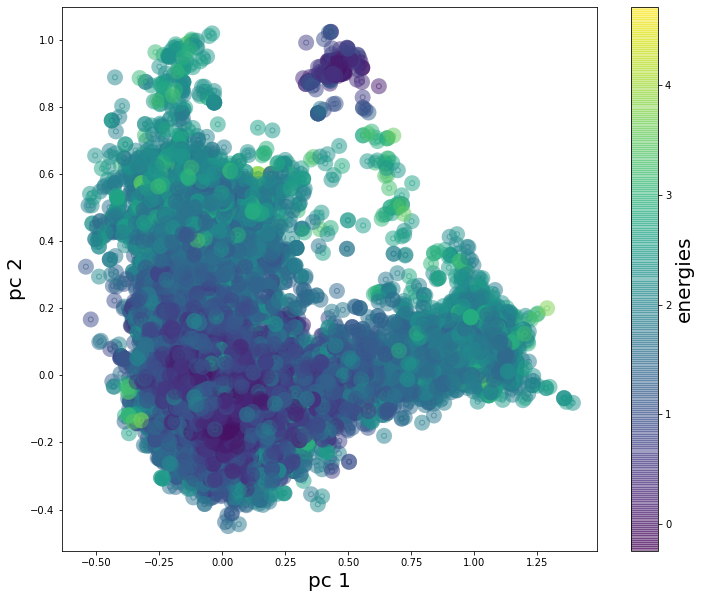


• PCA using Positions


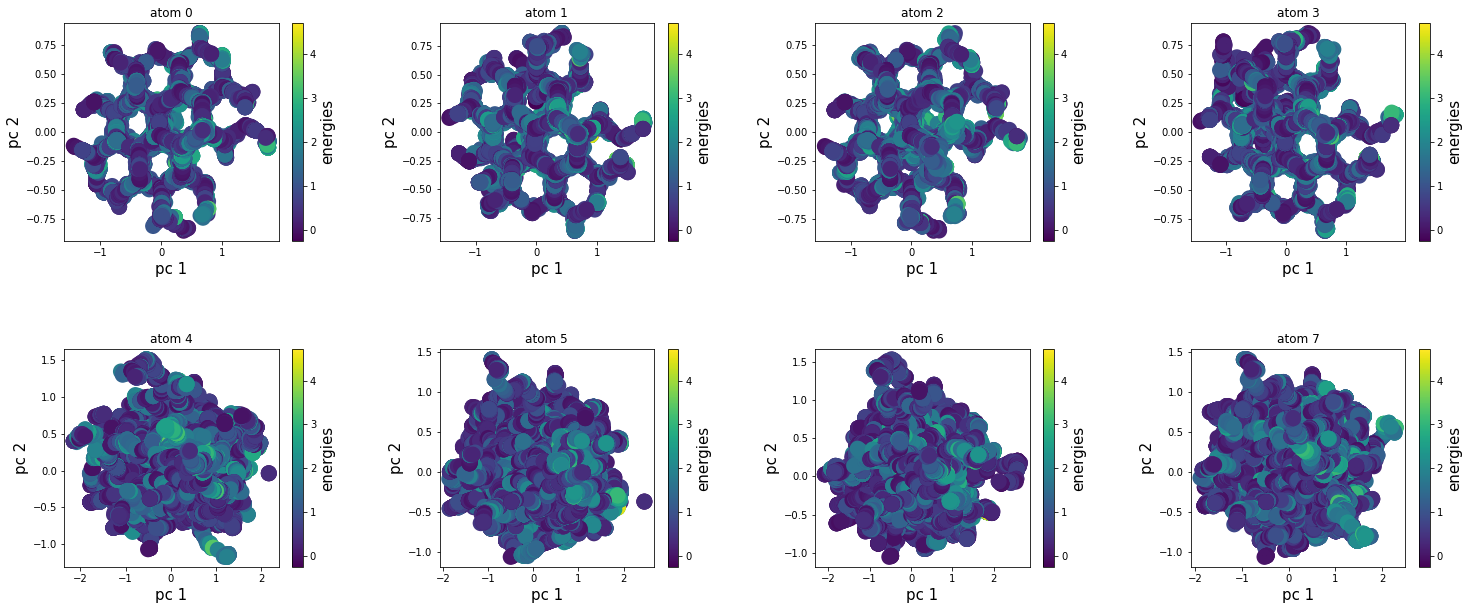

In [16]:
import shutil

%matplotlib inline

print('\u2022 PCA using Fingerprints')
plot_PCA(fps, per_atom=False)
print('\n\u2022 PCA using Positions')
plot_PCA(pos, per_atom=True)

#### NOTES
# PCA was performed separately for each atom. So each atom may have different principal components
# Need to find a way for the Featurization at the structure level